<a href="https://www.kaggle.com/code/amroaskar/house-prices?scriptVersionId=137383271" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Exploring the data

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Dropping columns with alot of NULL values

In [7]:
train.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [8]:
dropped_columns = train.columns[np.where(train.isnull().sum() > (train.shape[0] // 2))]
list(dropped_columns)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
train.drop(dropped_columns, axis=1, inplace=True)
test.drop(dropped_columns, axis=1, inplace=True)

In [10]:
train.shape

(1460, 77)

In [11]:
train.duplicated().sum()

0

In [12]:
train.select_dtypes('object').nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

Dropping columns with a bad correlation with the target

<Axes: >

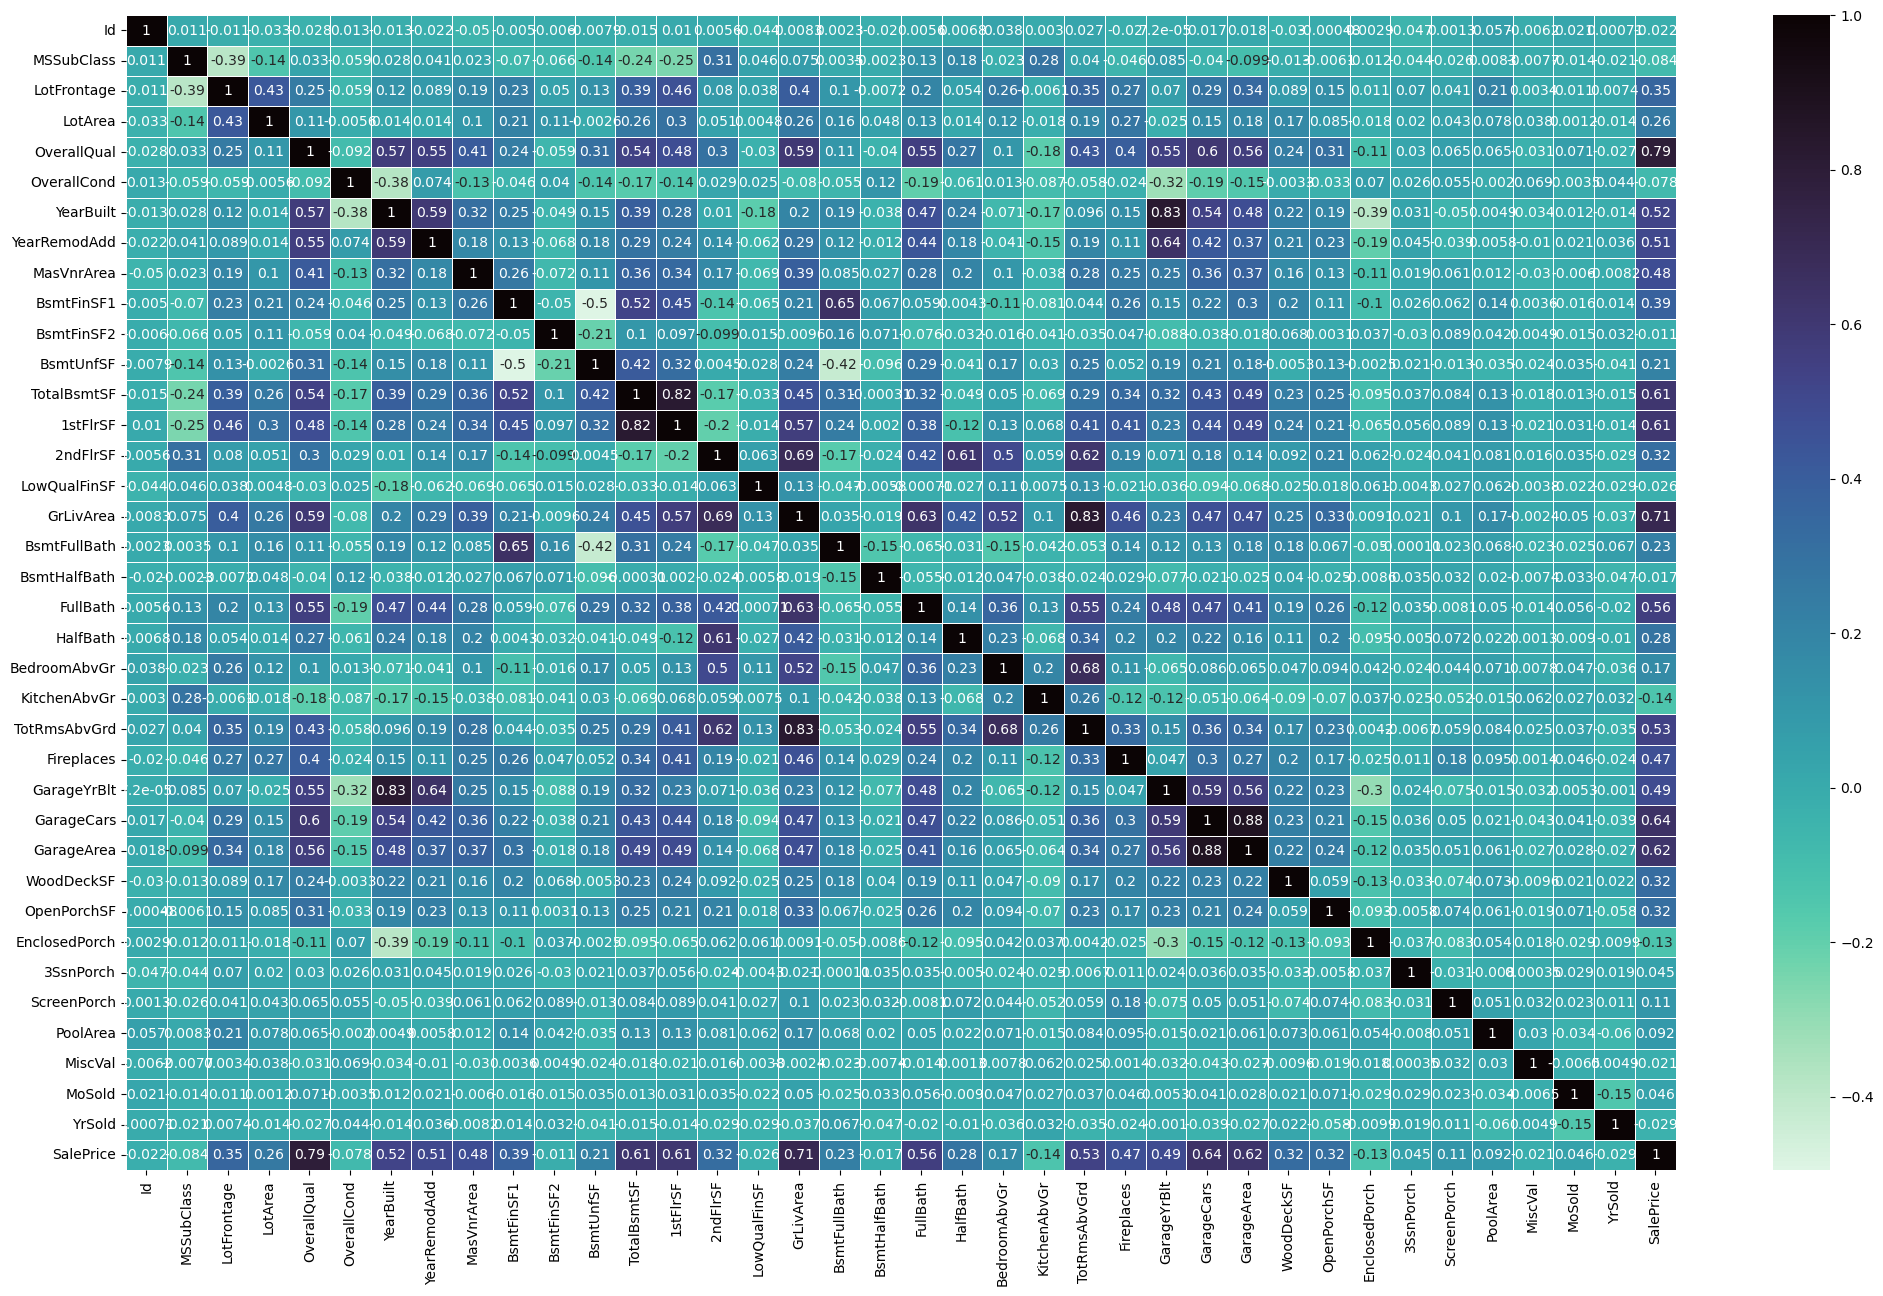

In [13]:
correlation = train.select_dtypes('number').corr()
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(correlation, ax=ax, annot=True, linewidths=0.5, cmap='mako_r')

In [14]:
train.select_dtypes('number').corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [15]:
train.drop(['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass'], axis=1, inplace=True)
test.drop(['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass'], axis=1, inplace=True)

In [16]:
train.shape

(1460, 67)

In [17]:
train.drop('FireplaceQu', axis=1, inplace=True)
test.drop('FireplaceQu', axis=1, inplace=True)
train.shape

(1460, 66)

In [18]:
train.drop('Id', axis=1, inplace=True)

In [19]:
train.select_dtypes('number').corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Dealing with outliers

In [20]:
where_to_check_outliers = train.select_dtypes('number').corr()['SalePrice'].sort_values(ascending=False)[1:11].index
where_to_check_outliers

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

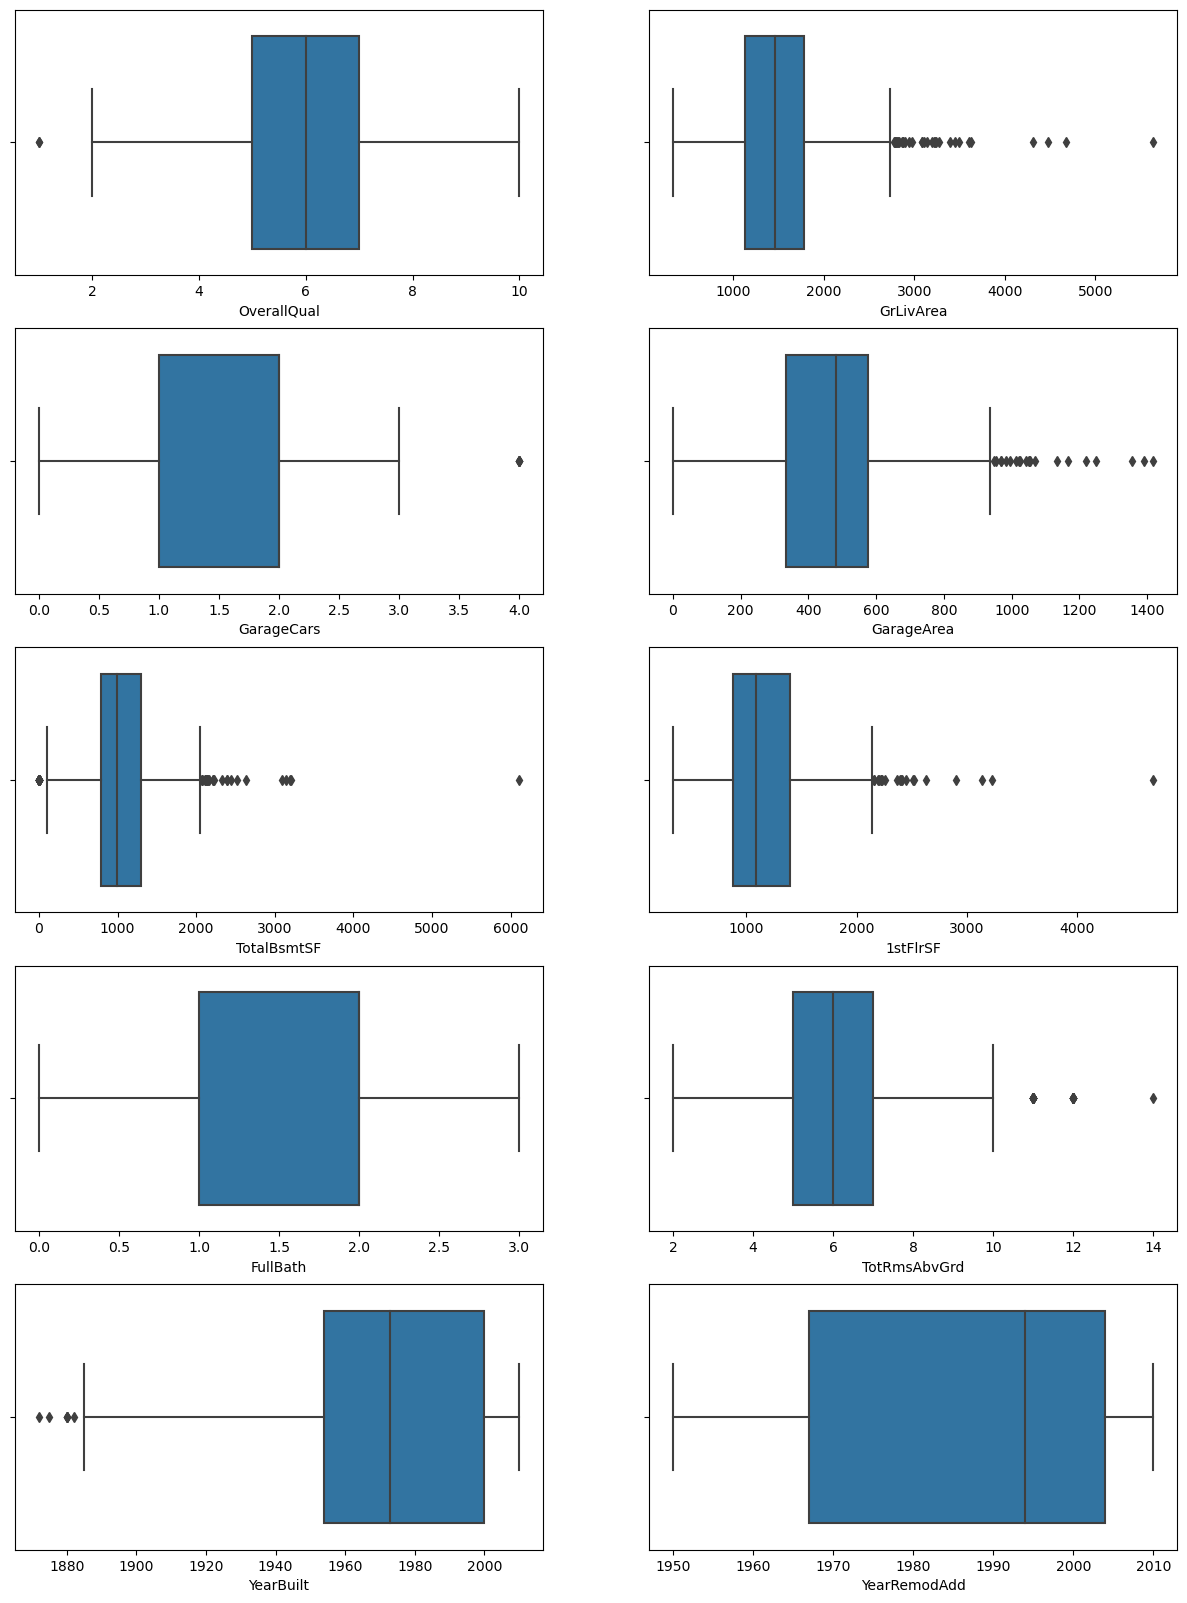

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
ax = ax.flatten()
for index, value in enumerate(where_to_check_outliers):
    sns.boxplot(data=train , x=value, ax=ax[index])

In [22]:
train.describe()[where_to_check_outliers]

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,472.980137,1057.429452,1162.626712,1.565068,6.517808,1971.267808,1984.865753
std,1.382997,525.480383,0.747315,213.804841,438.705324,386.587738,0.550916,1.625393,30.202904,20.645407
min,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,2.000000,1872.000000,1950.000000
25%,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000
50%,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000
75%,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000
max,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,14.000000,2010.000000,2010.000000


In [23]:
mask1 = train['OverallQual'] > -iqr(train['OverallQual']) * 1.5 + np.percentile(train['OverallQual'], 25)
mask2 = train['GrLivArea'] < iqr(train['GrLivArea']) * 1.5 + np.percentile(train['GrLivArea'], 75)
mask3 = train['GarageCars'] < iqr(train['GarageCars']) * 1.5 + np.percentile(train['GarageCars'], 75)
mask4 = train['GarageArea'] < iqr(train['GarageArea']) * 1.5 + np.percentile(train['GarageArea'], 75)
mask5 = train['TotalBsmtSF'] < iqr(train['TotalBsmtSF']) * 1.5 + np.percentile(train['TotalBsmtSF'], 75)
mask6 = train['TotalBsmtSF'] > -iqr(train['TotalBsmtSF']) * 1.5 + np.percentile(train['TotalBsmtSF'], 25)
mask7 = train['1stFlrSF'] < iqr(train['1stFlrSF']) * 1.5 + np.percentile(train['1stFlrSF'], 75)
mask8 = train['TotRmsAbvGrd'] < iqr(train['TotRmsAbvGrd']) * 1.5 + np.percentile(train['TotRmsAbvGrd'], 75)
mask9 = train['YearBuilt'] > -iqr(train['YearBuilt']) * 1.5 + np.percentile(train['YearBuilt'], 25)

In [24]:
train = train[mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9]

In [25]:
train.shape

(1294, 65)

In [26]:
train

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,61,0,0,WD,Normal,208500
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,TA,TA,Y,298,0,0,0,WD,Normal,181500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,42,0,0,WD,Normal,223500
3,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,TA,TA,Y,0,35,272,0,WD,Abnorml,140000
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,TA,Y,192,84,0,0,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,TA,TA,Y,0,40,0,0,WD,Normal,175000
1456,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,TA,TA,Y,349,0,0,0,WD,Normal,210000
1457,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,TA,TA,Y,0,60,0,0,WD,Normal,266500
1458,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,366,0,112,0,WD,Normal,142125


Dealing with skewed data

In [27]:
target = train['SalePrice'].copy()
train = train.drop('SalePrice', axis=1)

In [28]:
num_columns = train.select_dtypes('number').columns
num_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch'],
      dtype='object')

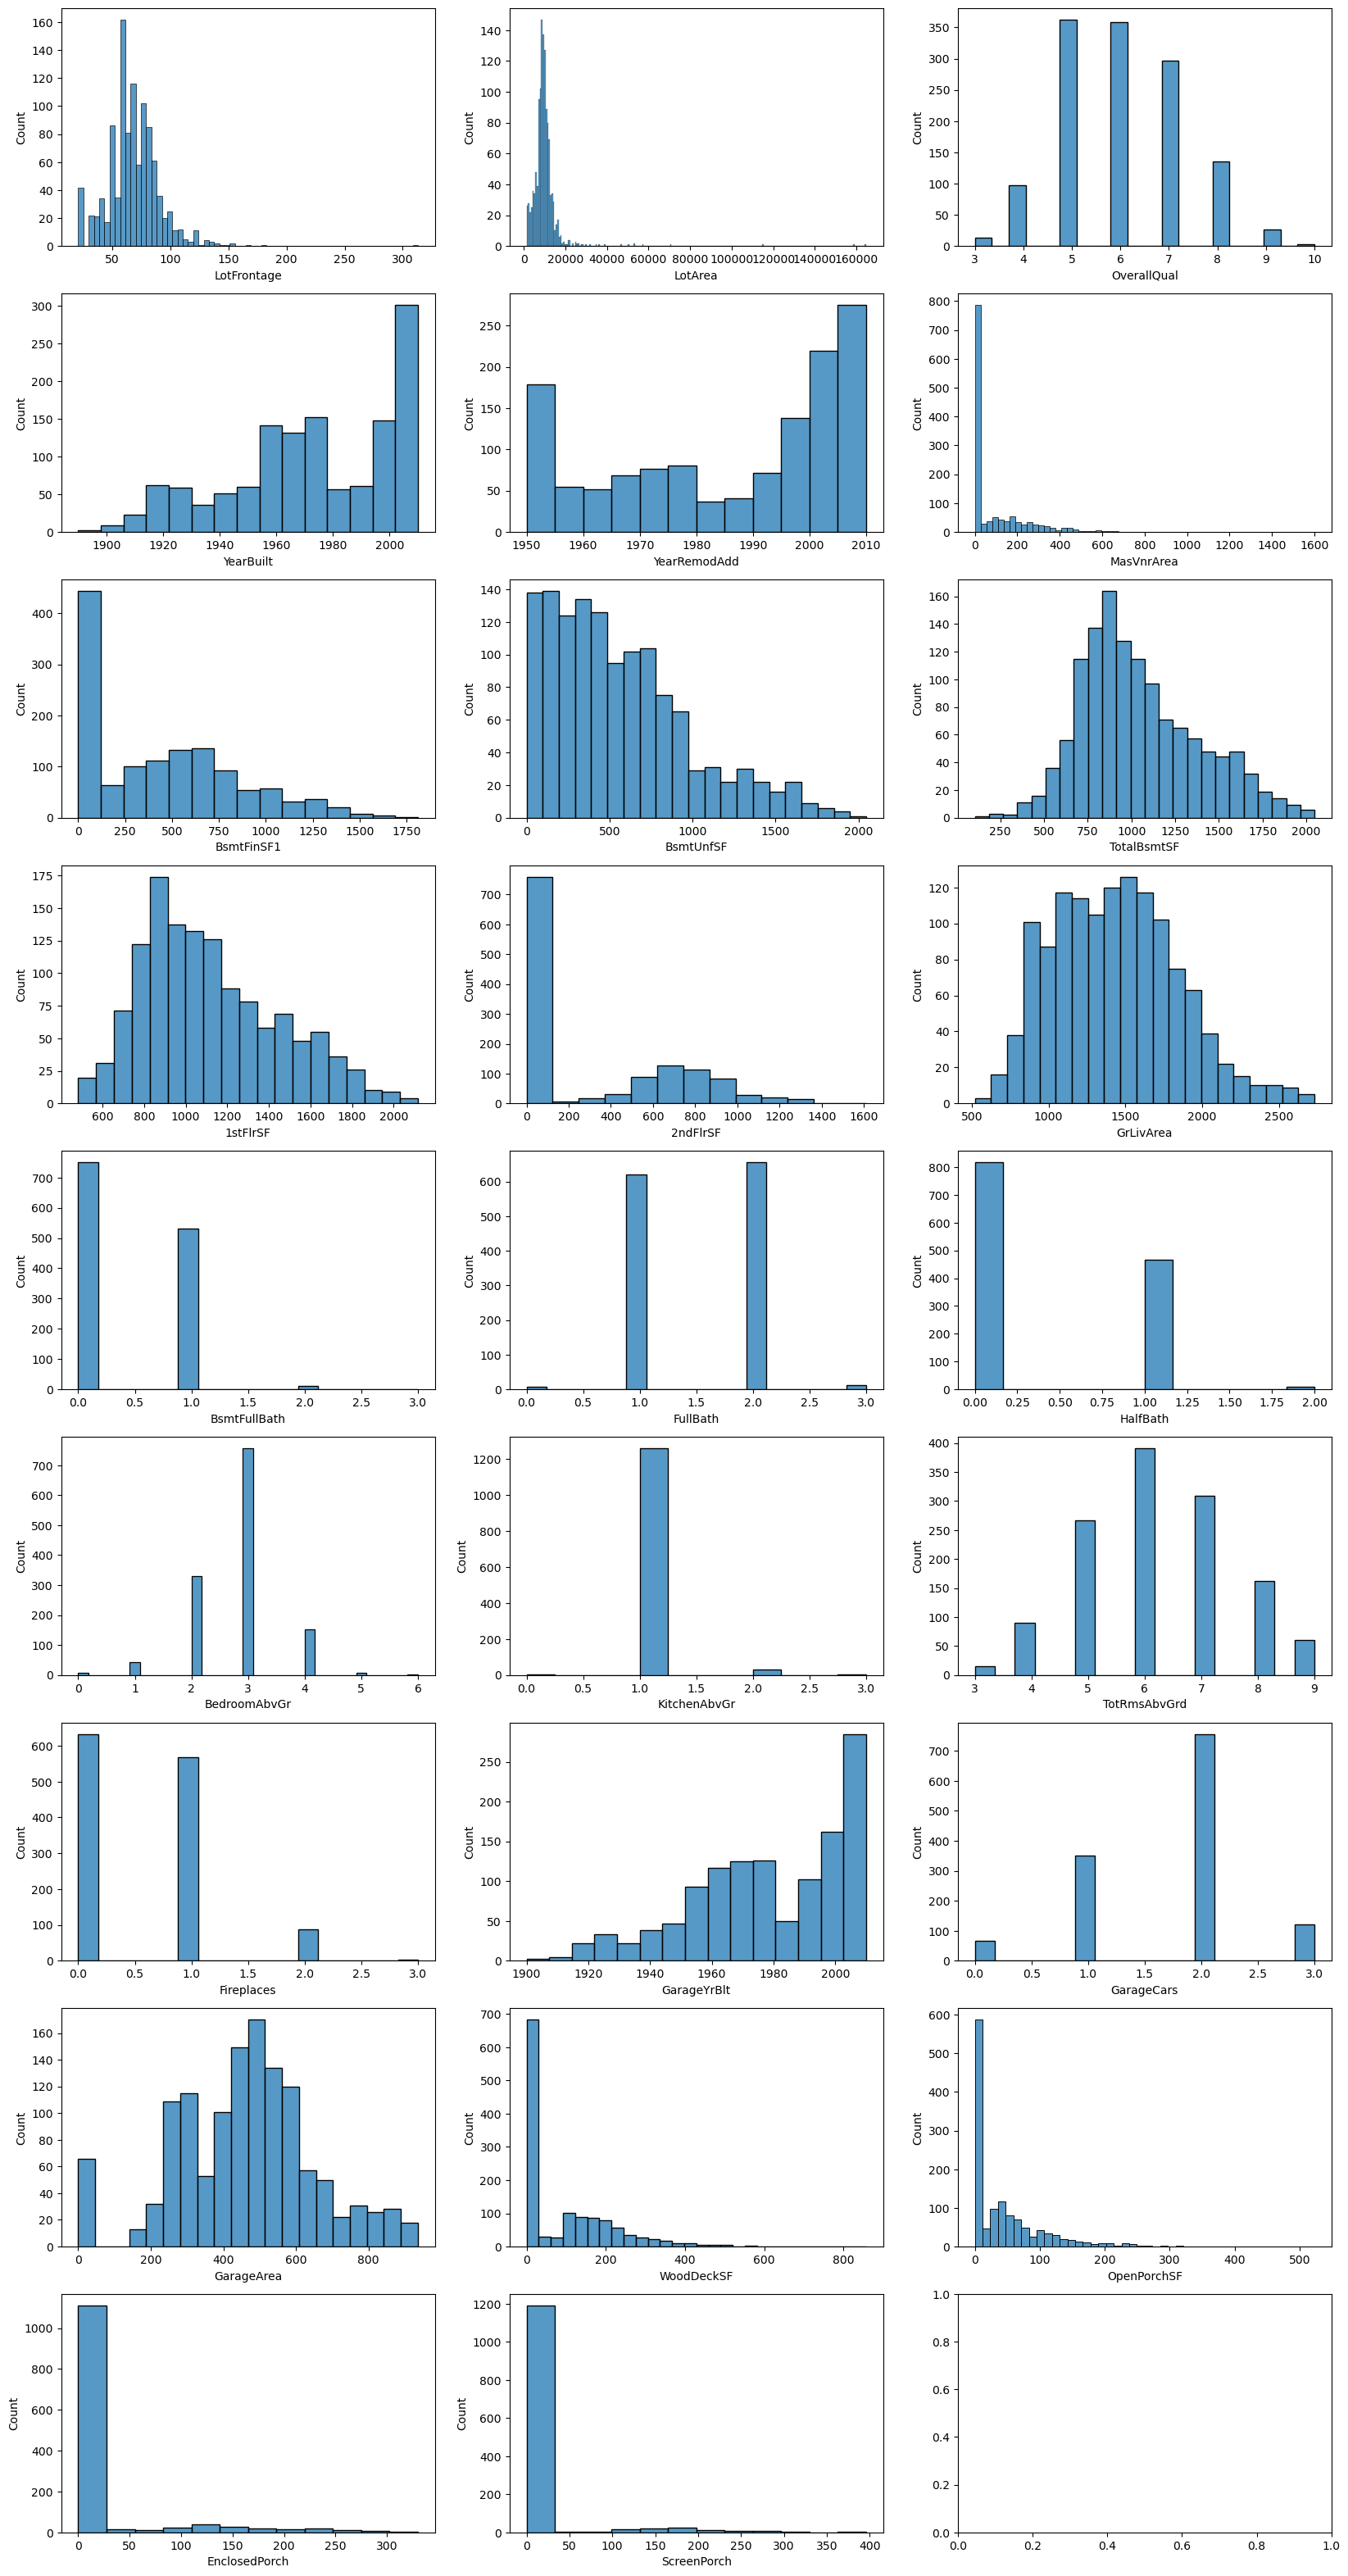

In [29]:
fig, ax = plt.subplots(9, 3, figsize=(20, 40))
ax = ax.flatten()
for index, value in enumerate(num_columns):
    sns.histplot(data=train, x=value, ax=ax[index])

In [30]:
skewness_check = (train.skew(numeric_only=True) > 1) | (train.skew(numeric_only=True) < -1)
skewed_columns = skewness_check[skewness_check==True].index
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'KitchenAbvGr', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch'],
      dtype='object')

In [31]:
np.seterr(divide = 'ignore')
sk_ = pd.DataFrame(np.select([train[skewed_columns]==0, train[skewed_columns] > 0, train[skewed_columns] < 0], [0, np.log(train[skewed_columns]), np.log(train[skewed_columns])]),columns=skewed_columns).set_index(train.index)
df_skew = train.drop(columns=skewed_columns).set_index(train.index)
train_skew = pd.concat([df_skew,sk_],axis=1)
train_skew = train_skew[train.columns.tolist()]
train_skew

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition
0,RL,4.174387,9.041922,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,548,TA,TA,Y,0.000000,4.110874,0.000000,0.0,WD,Normal
1,RL,4.382027,9.169518,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,460,TA,TA,Y,5.697093,0.000000,0.000000,0.0,WD,Normal
2,RL,4.219508,9.328123,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,608,TA,TA,Y,0.000000,3.737670,0.000000,0.0,WD,Normal
3,RL,4.094345,9.164296,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,642,TA,TA,Y,0.000000,3.555348,5.605802,0.0,WD,Abnorml
4,RL,4.430817,9.565214,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,836,TA,TA,Y,5.257495,4.430817,0.000000,0.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,4.127134,8.976768,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,460,TA,TA,Y,0.000000,3.688879,0.000000,0.0,WD,Normal
1456,RL,4.442651,9.486076,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,500,TA,TA,Y,5.855072,0.000000,0.000000,0.0,WD,Normal
1457,RL,4.189655,9.109636,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,252,TA,TA,Y,0.000000,4.094345,0.000000,0.0,WD,Normal
1458,RL,4.219508,9.181632,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,240,TA,TA,Y,5.902633,0.000000,4.718499,0.0,WD,Normal


In [32]:
skewness_check = (test.skew(numeric_only=True) > 1) | (test.skew(numeric_only=True) < -1)
skewed_columns = skewness_check[skewness_check==True].index
skewed_columns

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', 'GrLivArea',
       'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch'],
      dtype='object')

In [33]:
sk_ = pd.DataFrame(np.select([test[skewed_columns]==0, test[skewed_columns] > 0, test[skewed_columns] < 0], [0, np.log(test[skewed_columns]), np.log(test[skewed_columns])]),columns=skewed_columns).set_index(test.index)
df_skew = test.drop(columns=skewed_columns).set_index(test.index)
test_skew = pd.concat([df_skew,sk_],axis=1)
test_skew = test_skew[test.columns.tolist()]
test_skew

,Id,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition
0,1461,RH,80.0,9.360655,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,730.0,TA,TA,Y,4.941642,0.000000,0.0,4.787492,WD,Normal
1,1462,RL,81.0,9.565704,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,312.0,TA,TA,Y,5.973810,3.583519,0.0,0.000000,WD,Normal
2,1463,RL,74.0,9.534595,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,482.0,TA,TA,Y,5.356586,3.526361,0.0,0.000000,WD,Normal
3,1464,RL,78.0,9.208138,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,470.0,TA,TA,Y,5.886104,3.583519,0.0,0.000000,WD,Normal
4,1465,RL,43.0,8.518193,Pave,IR1,HLS,AllPub,Inside,Gtl,...,506.0,TA,TA,Y,0.000000,4.406719,0.0,4.969813,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,RM,21.0,7.568379,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,NaN,NaN,Y,0.000000,0.000000,0.0,0.000000,WD,Normal
1455,2916,RM,21.0,7.546446,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,286.0,TA,TA,Y,0.000000,3.178054,0.0,0.000000,WD,Abnorml
1456,2917,RL,160.0,9.903488,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,576.0,TA,TA,Y,6.161207,0.000000,0.0,0.000000,WD,Abnorml
1457,2918,RL,62.0,9.253496,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,NaN,NaN,Y,4.382027,3.465736,0.0,0.000000,WD,Normal


In [34]:
data = train_skew

Test set Id column

In [35]:
submission = pd.DataFrame()
submission.index = test_skew['Id']
test_skew.drop('Id', axis=1, inplace=True)

Impute

In [36]:
train_numerical_columns = data.select_dtypes('number')
train_categorical_columns = data.select_dtypes('object')
test_numerical_columns = test_skew.select_dtypes('number')
test_categorical_columns = test_skew.select_dtypes('object')

In [37]:
num_imputer = SimpleImputer(strategy='mean')
train_num = num_imputer.fit_transform(train_numerical_columns)
test_num = num_imputer.fit_transform(test_numerical_columns)

In [38]:
cat_imputer = SimpleImputer(strategy='most_frequent')
train_cat = cat_imputer.fit_transform(train_categorical_columns)
test_cat = cat_imputer.fit_transform(test_categorical_columns)

In [39]:
train_num = pd.DataFrame(train_num, columns=train_numerical_columns.columns)
train_cat = pd.DataFrame(train_cat, columns=train_categorical_columns.columns)
train = pd.concat([train_num, train_cat], axis=1).set_index(data.index)

In [40]:
test_num = pd.DataFrame(test_num, columns=test_numerical_columns.columns)
test_cat = pd.DataFrame(test_cat, columns=test_categorical_columns.columns)
test = pd.concat([test_num, test_cat], axis=1).set_index(test_skew.index)

Scale ==> get_dummies

In [41]:
train = pd.get_dummies(train)      # gives shape (1294, 251)
test = pd.get_dummies(test)        # gives shape (1459, 245)
encoded_train, encoded_test = train.align(test, join='inner', axis=1)  # inner join

In [42]:
train.shape

(1294, 251)

In [43]:
test.shape

(1459, 244)

In [44]:
encoded_train.shape

(1294, 239)

In [45]:
encoded_test.shape

(1459, 239)

Scaler

In [46]:
scaler = StandardScaler()
final_train = scaler.fit_transform(encoded_train)
final_test = scaler.fit_transform(encoded_test)

Splitting the Data

In [47]:
X_train, X_cv, y_train, y_cv = train_test_split(final_train, target, test_size=0.25, random_state=42)

Linear regression

In [48]:
regression = LinearRegression()
regression.fit(X_train, y_train)
regression_train_predict = regression.predict(X_train)
regression_mse = cross_val_score(regression, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
regression_rmse = np.sqrt(-regression_mse)
print(np.mean(regression_rmse))
print(regression.score(X_train, y_train))

9.497642261315576e+16
0.9344753409933774


In [49]:
regression_cv_predict = regression.predict(X_cv)
regression_mse = cross_val_score(regression, X_cv, y_cv, cv=10, scoring='neg_mean_squared_error')
regression_rmse = np.sqrt(-regression_mse)
print(np.mean(regression_rmse))
print(regression.score(X_cv, y_cv))

1.0273611136346358e+16
-6.73807317371248e+16


Lasso

In [50]:
lasso_params = [{
    'alpha':np.arange(0.001, 10)
}]
lasso = Lasso(alpha=0.001)
lasso_grid_search = GridSearchCV(lasso, lasso_params, cv=10, scoring='neg_mean_squared_error',return_train_score=True)
lasso_grid_search.fit(X_train, y_train)
lasso = lasso_grid_search.best_estimator_
lasso.fit(X_train, y_train)
lasso_train_predict = lasso.predict(X_train)
lasso_mse = cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_mse)
print(np.mean(lasso_rmse))
print(lasso.score(X_train, y_train))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+11, tolerance: 3.352e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+11, tolerance: 3.431e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+11, tolerance: 3.415e

22096.613370881765
0.9342680884275174


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.794e+09, tolerance: 3.380e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.401e+09, tolerance: 3.544e+08
  model = cd_fast.enet_coordinate_descent(


In [51]:
lasso_grid_search.best_estimator_

Lasso(alpha=9.000999999999998)

In [52]:
lasso_cv_predict = lasso.predict(X_cv)
lasso_mse = cross_val_score(lasso, X_cv, y_cv, cv=10, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_mse)
print(np.mean(lasso_rmse))
print(lasso.score(X_cv, y_cv))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.927e+08, tolerance: 1.129e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.977e+09, tolerance: 1.044e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.958e+09, tolerance: 1.071e

27170.875477751008
0.8951449447915039


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e+09, tolerance: 1.103e+08
  model = cd_fast.enet_coordinate_descent(


Ridge

In [53]:
ridge_params = [{
    'alpha':np.arange(0.001, 10)
}]
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error',return_train_score=True)
ridge_grid_search.fit(X_train, y_train)
ridge = ridge_grid_search.best_estimator_
ridge.fit(X_train, y_train)
ridge_train_predict = ridge.predict(X_train)
ridge_mse = cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_mse)
print(np.mean(ridge_rmse))
print(ridge.score(X_train, y_train))

21551.298677008566
0.9337060713141441


In [54]:
ridge_grid_search.best_estimator_

Ridge(alpha=9.000999999999998)

In [55]:
ridge_cv_predict = ridge.predict(X_cv)
ridge_mse = cross_val_score(ridge, X_cv, y_cv, cv=10, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_mse)
print(np.mean(ridge_rmse))
print(ridge.score(X_cv, y_cv))

23017.22537016258
0.8978358155812808


Final model I will choose Lasso ==> gives the best cv score

In [56]:
final_test

array([[ 0.55558736,  0.561781  , -0.75110125, ..., -0.13469875,
         0.46021084, -0.29936452],
       [ 0.60423927,  0.97036134, -0.05487716, ..., -0.13469875,
         0.46021084, -0.29936452],
       [ 0.26367594,  0.90837362, -0.75110125, ..., -0.13469875,
         0.46021084, -0.29936452],
       ...,
       [ 4.44773966,  1.64342638, -0.75110125, ..., -0.13469875,
        -2.17291708, -0.29936452],
       [-0.3201469 ,  0.34825549, -0.75110125, ..., -0.13469875,
         0.46021084, -0.29936452],
       [ 0.26367594,  0.18651909,  0.64134693, ..., -0.13469875,
         0.46021084, -0.29936452]])

In [57]:
submission['SalePrice'] = lasso.predict(final_test)

In [58]:
submission.to_csv('submission.csv')